# Лабораторная работа №3
Группа 3530903/70301  
Ижко Георгий, Шергалис Донат, Сидорова Елена

### 100,000 UK Used Car Data set
https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes


1. Выбрать набор данных для своей группы: <br>
    3530203_70101: Audi <br>
    3530203_70102: BMW <br>
    **3530903_70301: Ford** <br>
    3530903_70302: Mercedes<br>
    
2. Разбить данные на тренировочные и тестовые (70% на 30%, random_state=10).
3. Попытаться обучить регрессии c лучшим качеством. 


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split


In [2]:
auto_data = pd.read_csv("data/ford.csv", delimiter=',\s*', engine='python')
auto_data

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
...,...,...,...,...,...,...,...,...,...
17960,Fiesta,2016,7999,Manual,31348,Petrol,125,54.3,1.2
17961,B-MAX,2017,8999,Manual,16700,Petrol,150,47.1,1.4
17962,B-MAX,2014,7499,Manual,40700,Petrol,30,57.7,1.0
17963,Focus,2015,9999,Manual,7010,Diesel,20,67.3,1.6


## Анализ датасета

In [3]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17965 entries, 0 to 17964
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         17965 non-null  object 
 1   year          17965 non-null  int64  
 2   price         17965 non-null  int64  
 3   transmission  17965 non-null  object 
 4   mileage       17965 non-null  int64  
 5   fuelType      17965 non-null  object 
 6   tax           17965 non-null  int64  
 7   mpg           17965 non-null  float64
 8   engineSize    17965 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 1.2+ MB


In [4]:
auto_data.describe()

,year,price,mileage,tax,mpg,engineSize
count,17965.000000,17965.000000,17965.000000,17965.000000,17965.000000,17965.000000
mean,2016.866574,12279.756415,23363.630504,113.334539,57.906991,1.350827
std,2.050346,4741.382606,19472.114690,62.010438,10.125977,0.432371
min,1996.000000,495.000000,1.000000,0.000000,20.800000,0.000000
25%,2016.000000,8999.000000,9987.000000,30.000000,52.300000,1.000000
50%,2017.000000,11291.000000,18243.000000,145.000000,58.900000,1.200000
75%,2018.000000,15299.000000,31064.000000,145.000000,65.700000,1.500000
max,2060.000000,54995.000000,177644.000000,580.000000,201.800000,5.000000


# Анализ выбросов

* `year=2060` -- явная ошибка
* `price=495` -- реалистична
* `price=54995` --  стоит проверить
* `mpg=201.8` -- вероятно выброс (кол-во миль на галон)
* `mileage=177644` -- реалистичный пробег
* `tax=0` -- наверное корректное значение
* `engineSize=0` -- пустое значение
* `engineSize=5` -- стоит проверить

### Выбросы engineSize

In [5]:
def get_engine_by_size(size, df = auto_data):
    return df[df.engineSize == size]

zero_engine = get_engine_by_size(0)
print(len(zero_engine), ":", set(zero_engine.fuelType))

51 : {'Hybrid', 'Diesel', 'Petrol'}


Попахивает неправдой.

In [6]:
auto_data.drop(zero_engine.index, inplace=True)

In [7]:
big_engine = get_engine_by_size(5)
set(big_engine.model)

{'Mondeo', 'Mustang'}

Что здесь забыл Mondeo? Выпихиваем.

In [8]:
mondeo_liar = big_engine[big_engine.model == 'Mondeo']
auto_data.drop(mondeo_liar.index, inplace=True)

### Выбросы year

In [9]:
def get_year_over(year = 2021, df = auto_data):
    return df[df.year > year]

from_future = get_year_over()
from_future

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
17726,Fiesta,2060,6495,Automatic,54807,Petrol,205,42.8,1.4


Насколько нам известно, Эммет Браун и Марти МакФлай ездили на DeLorean, а не на Ford Fiesta.   
Можно предположить, что на самом деле там должно быть значение 2006. А можно просто хладнокровно вырвать эту строчку из датасета.

In [10]:
auto_data.drop(from_future.index, inplace=True)

### Выбросы price

In [11]:
def get_price_over(threshold, df = auto_data):
    return df[df.price > threshold]

overprice = get_price_over(50000)
overprice

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
11912,Focus,2018,54995,Manual,11000,Petrol,145,36.7,2.3


Для Фокуса 55к бачинских многовато будет. [Разве что...](https://i.pinimg.com/originals/8a/32/12/8a32122ffae41e0c2d10ebb7ecc8e595.jpg) Но это всё равно выброс. Выбрасываем выброс.

In [12]:
auto_data.drop(overprice.index, inplace=True)

In [13]:
set(get_price_over(40000).model)

{'Mustang'}

Для Мустанга цена похожа на правду.

### Выбросы mpg

In [21]:
def get_mpg_over(threshold, df = auto_data):
    return df[df.mpg > threshold]

high_mpg = get_mpg_over(100)
high_mpg
# print(len(high_mpg), ":", set(high_mpg.model))

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize


<AxesSubplot:>

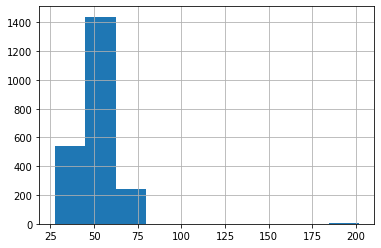

In [15]:
auto_data[auto_data.model == 'Kuga'].mpg.hist()

Реальные значения mpg для Ford Kuga находятся в пределах 60: https://www.honestjohn.co.uk/realmpg/ford/kuga-2013

In [16]:
auto_data.drop(high_mpg.index, inplace=True)

### Выбросы mileage

<AxesSubplot:>

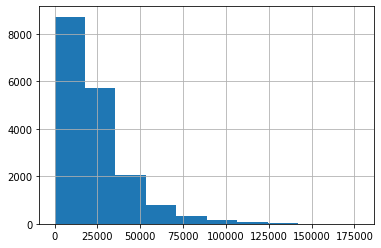

In [23]:
auto_data.mileage.hist()

Распределение выглядит реалистично.

### Проверка результата выброса выбросов:

In [17]:
auto_data.describe()

,year,price,mileage,tax,mpg,engineSize
count,17906.000000,17906.000000,17906.000000,17906.000000,17906.000000,17906.000000
mean,2016.861946,12273.357199,23380.129733,113.326818,57.872808,1.354094
std,2.025786,4721.935913,19475.535522,62.016213,9.837297,0.425664
min,1996.000000,495.000000,1.000000,0.000000,20.800000,1.000000
25%,2016.000000,8999.000000,9995.250000,30.000000,52.300000,1.000000
50%,2017.000000,11291.000000,18254.500000,145.000000,58.900000,1.200000
75%,2018.000000,15298.750000,31095.250000,145.000000,65.700000,1.500000
max,2020.000000,49999.000000,177644.000000,580.000000,88.300000,5.000000


In [18]:
X, Y = auto_data.drop(['price'], axis=1), auto_data['price']

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)